In [468]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import requests
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_recall_curve, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score


# Data Preproccessing

In [469]:
def get_series(url):
    r = requests.get(url)
    data = r.json().get("values", [])
    df = pd.DataFrame(data)
    if len(df) == 0:
        return pd.DataFrame()  
    
    df["x"] = pd.to_datetime(df["x"], unit="s")
    df = df.rename(columns={"x": "date", "y": url.split("/")[-1]})
    df = df.set_index("date")
    return df

In [470]:
# api calls to get various bitcoin time series data
difficulty = get_series("https://api.blockchain.info/charts/difficulty?timespan=5year&sampled=true&format=json")
hashrate = get_series("https://api.blockchain.info/charts/hash-rate?timespan=5year&sampled=true&format=json")
price = get_series("https://api.blockchain.info/charts/market-price?timespan=5year&sampled=true&format=json")
miner_rev = get_series("https://api.blockchain.info/charts/miners-revenue?timespan=5year&sampled=true&format=json")

In [471]:
# merge all series on the date index using outer join
df = difficulty.join([hashrate, price, miner_rev], how="outer")

# reindex to a **continuous daily index**
daily_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
df = df.reindex(daily_index)

# fill missing values with forward-fill
df = df.ffill()

df.columns = ["difficulty", "hashrate", "price", "miner_rev_usd"]

# compute hashrate pct change
df["hashrate_pct_change"] = df["hashrate"].pct_change() * 100

# look at difficutly changes around hashrate crashes
df["difficulty_pct_change_next"] = df["difficulty"].pct_change().shift(-1) * 100

# hashprice
df["hashprice"] = df["miner_rev_usd"] / df["hashrate"]
df["hashprice_change_next"] = df["hashprice"].pct_change().shift(-1) * 100

df['hashrate_ma30'] = df['hashrate'].rolling(30).mean()
df['hashrate_ma60'] = df['hashrate'].rolling(60).mean()

# EDA

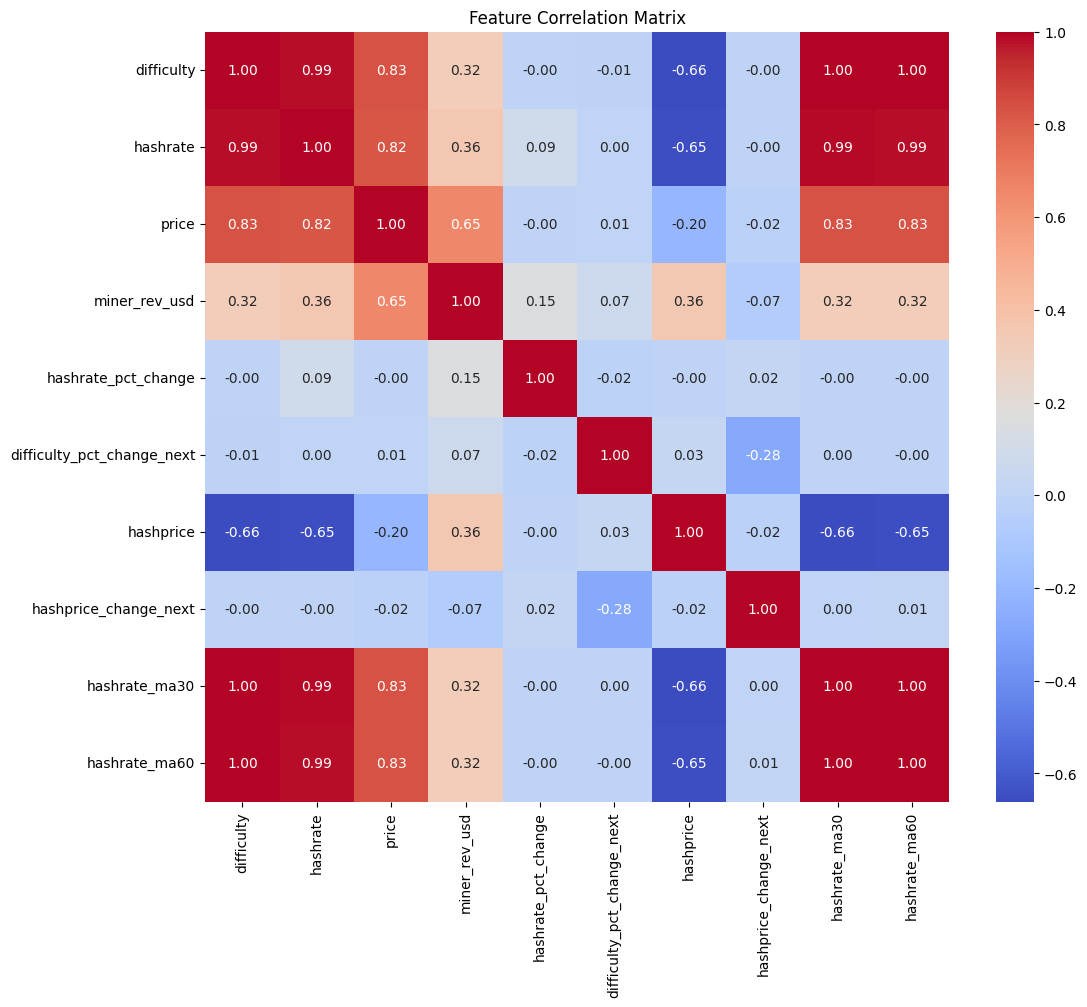

In [472]:
# correlation matrix to see feature relationships using mathplotlib
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

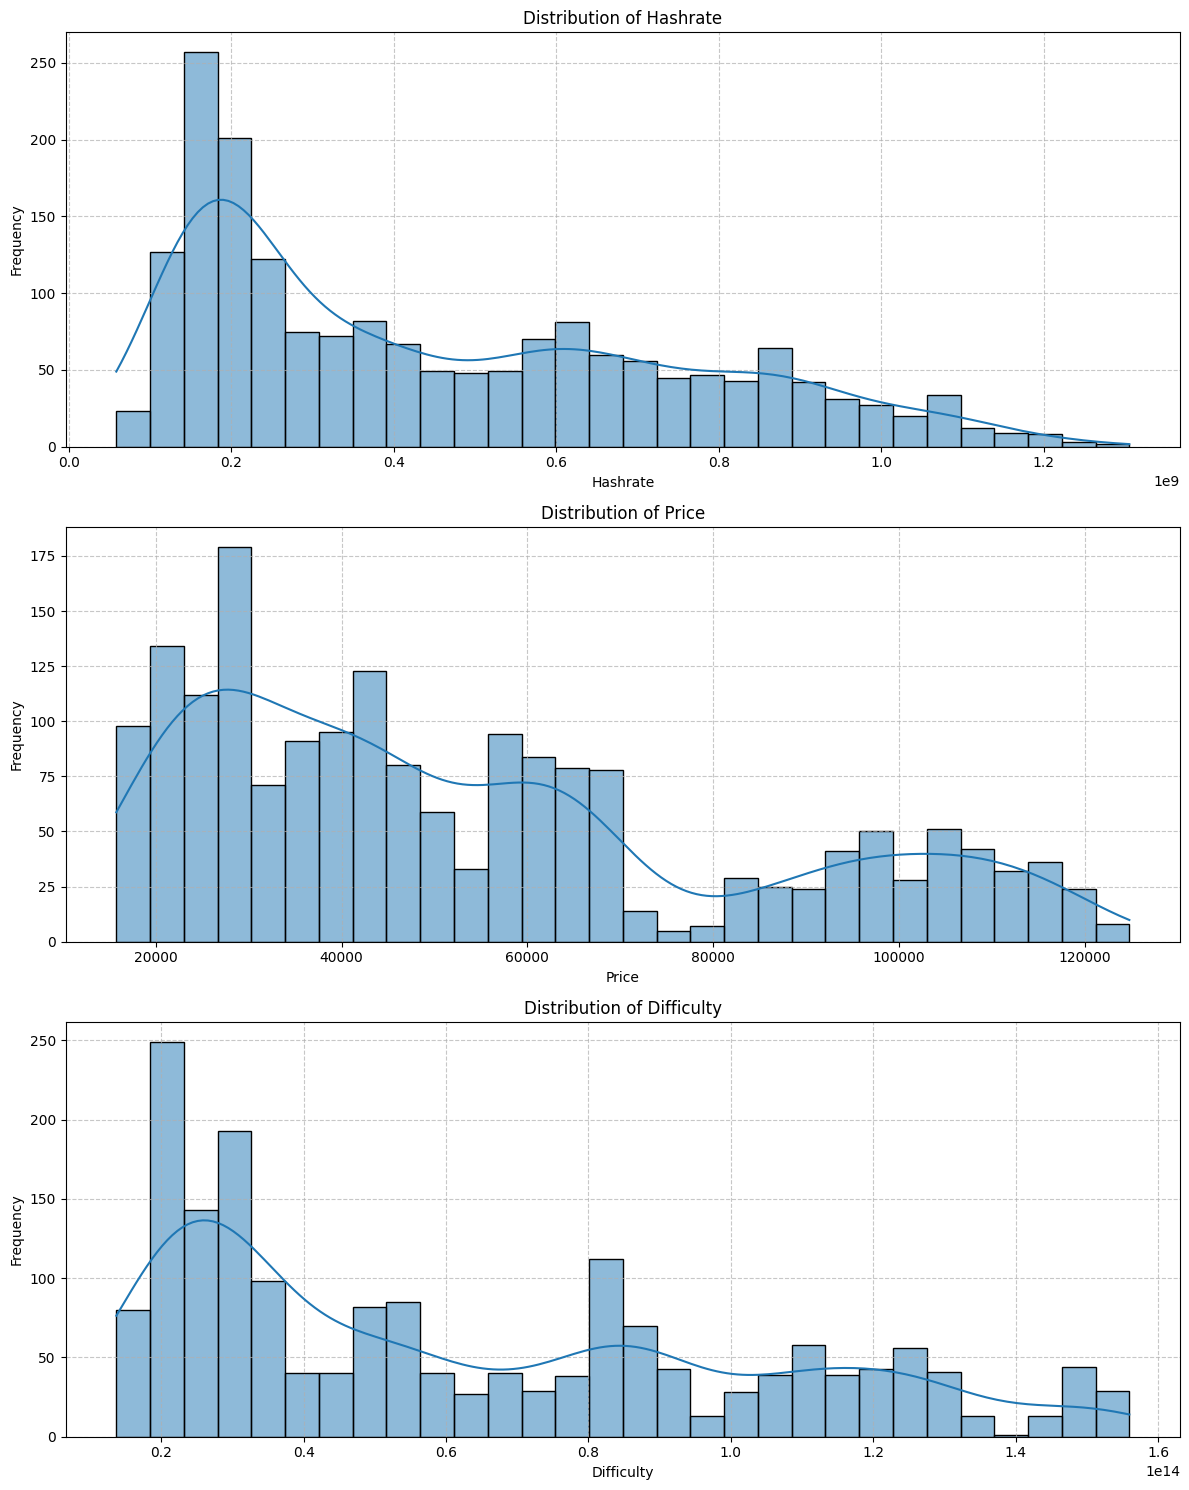

In [473]:
# only include hashrate, price, and difficulty 
num_cols = ['hashrate', 'price', 'difficulty']

# Create a figure and a set of subplots, one for each numerical column
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(12, 5 * len(num_cols)))

# Ensure axes is an array even if there's only one subplot
if len(num_cols) == 1:
    axes = [axes]

# Plot histogram for each numerical column
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {col.replace("_", " ").title()}')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.7)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

# Feature Engineering

In [474]:
# 1. Lagged features (what happened recently matters)
df['hashrate_lag1'] = df['hashrate'].shift(1)
df['hashrate_lag7'] = df['hashrate'].shift(7)

# Price percentage change
df['price_pct_change'] = df['price'].pct_change() * 100

# 2. Percentage changes (momentum indicators)
df['hashprice_pct_change'] = df['hashprice'].pct_change() * 100

df['hashrate_volatility_7d'] = df['hashrate_pct_change'].rolling(7).std()

# 5. Distance from moving averages (divergence indicator)
df['hashrate_distance_from_ma30'] = ((df['hashrate'] - df['hashrate_ma30']) / df['hashrate_ma30']) * 100
df['hashrate_distance_from_ma60'] = ((df['hashrate'] - df['hashrate_ma60']) / df['hashrate_ma60']) * 100

# 6. Cumulative metrics (how long has stress lasted?)
df['days_below_ma60'] = (df['hashrate'] < df['hashrate_ma60']).astype(int).rolling(30).sum()
df['consecutive_decline_days'] = (df['hashrate_pct_change'] < 0).astype(int)
df['consecutive_decline_days'] = df['consecutive_decline_days'].groupby((df['consecutive_decline_days'] != df['consecutive_decline_days'].shift()).cumsum()).cumsum()

# 8. Flag for hash ribbons
df['hash_ribbon'] = (df['hashrate_ma30'] < df['hashrate_ma60']).astype(int) # hash ribbons, if 30ma < 60ma, then 1 else 0

# Target: predict capitulation 3 days ahead using hash_ribbon
df['target'] = df['hash_ribbon'].shift(-7)

df = df.dropna()  # drop rows with NaN values created by feature engineering

# EDA Pt 2: New Features

In [475]:
# look at what is happening to price and hashprice during capitulation periods

# Identify the start of a capitulation period
df['capitulation_start'] = (df['hash_ribbon'] == 1) & (df['hash_ribbon'].shift(1) == 0)

# Get the indices where capitulation starts
capitulation_start_dates = df[df['capitulation_start']].index

print("Capitulation Start Dates & days_below_ma60 on start date:")
for date in capitulation_start_dates:
    days_below = df.loc[date, 'days_below_ma60']
    print(f"{date.date()}: {days_below} days below 60MA in prior 30 days")

# Collect statistics for PERIOD-TO-PERIOD changes (start to end of each period)
all_price_period_changes = []
all_hashprice_period_changes = []
all_durations = []
all_price_drawdowns = []
all_hashprice_drawdowns = []

# Analyze each capitulation period
for start_date in capitulation_start_dates:
    # Find the end of the capitulation period
    end_date_series = df.loc[start_date:].query('hash_ribbon == 0')
    if not end_date_series.empty:
        end_date = end_date_series.index[0]
        period_df = df.loc[start_date:end_date].copy()
        
        duration = (end_date - start_date).days
        all_durations.append(duration)
        
        price_start = period_df['price'].iloc[0]
        price_end = period_df['price'].iloc[-1]
        price_min = period_df['price'].min()
        price_change_pct = ((price_end - price_start) / price_start) * 100
        price_drawdown = ((price_min - price_start) / price_start) * 100
        
        hashprice_start = period_df['hashprice'].iloc[0]
        hashprice_end = period_df['hashprice'].iloc[-1]
        hashprice_min = period_df['hashprice'].min()
        hashprice_change_pct = ((hashprice_end - hashprice_start) / hashprice_start) * 100
        hashprice_drawdown = ((hashprice_min - hashprice_start) / hashprice_start) * 100

        # Collect period-to-period changes
        all_price_period_changes.append(price_change_pct)
        all_hashprice_period_changes.append(hashprice_change_pct)
        all_price_drawdowns.append(price_drawdown)
        all_hashprice_drawdowns.append(hashprice_drawdown)
        
        print(f"\nCapitulation Period: {start_date.date()} to {end_date.date()} ({duration} days)")
        print(f"  Price: Starts at ${price_start:,.2f}, ends at ${price_end:,.2f} (Change: {price_change_pct:.2f}%)")
        print(f"    - Max Drawdown during period: {price_drawdown:.2f}% (Price hit ${price_min:,.2f})")
        print(f"  Hashprice: Starts at {hashprice_start:.6f}, ends at {hashprice_end:.6f} (Change: {hashprice_change_pct:.2f}%)")
        print(f"    - Max Drawdown during period: {hashprice_drawdown:.2f}% (Hashprice hit {hashprice_min:.6f})")

Capitulation Start Dates & days_below_ma60 on start date:
2021-04-24: 10.0 days below 60MA in prior 30 days
2021-04-26: 10.0 days below 60MA in prior 30 days
2021-06-03: 18.0 days below 60MA in prior 30 days
2022-06-09: 14.0 days below 60MA in prior 30 days
2022-07-05: 15.0 days below 60MA in prior 30 days
2022-11-27: 13.0 days below 60MA in prior 30 days
2023-07-12: 12.0 days below 60MA in prior 30 days
2023-07-15: 14.0 days below 60MA in prior 30 days
2023-08-08: 16.0 days below 60MA in prior 30 days
2024-05-14: 15.0 days below 60MA in prior 30 days
2024-06-19: 18.0 days below 60MA in prior 30 days
2024-10-07: 12.0 days below 60MA in prior 30 days
2025-01-31: 15.0 days below 60MA in prior 30 days
2025-02-04: 16.0 days below 60MA in prior 30 days
2025-03-17: 17.0 days below 60MA in prior 30 days
2025-05-15: 14.0 days below 60MA in prior 30 days
2025-05-22: 14.0 days below 60MA in prior 30 days
2025-06-25: 13.0 days below 60MA in prior 30 days
2025-06-27: 13.0 days below 60MA in prior 

In [476]:
print("\n" + "="*70)
print("AGGREGATE STATISTICS ACROSS ALL CAPITULATION PERIODS")
print("="*70)
print(f"Total number of capitulation periods: {len(capitulation_start_dates)}")
print(f"Average duration: {np.mean(all_durations):.1f} days (Std: {np.std(all_durations):.1f})")
print(f"Max duration: {np.max(all_durations)} days")
print(f"Min duration: {np.min(all_durations)} days")

print(f"\nPrice Change (Start to End of Period):")
print(f"  Average: {np.mean(all_price_period_changes):.2f}%")
print(f"  Std Dev: {np.std(all_price_period_changes):.2f}%")
print(f"  Median: {np.median(all_price_period_changes):.2f}%")
print(f"  Max Change: {np.max(all_price_period_changes):.2f}%")
print(f"  Min Change: {np.min(all_price_period_changes):.2f}%")

print(f"\nHashprice Change (Start to End of Period):")
print(f"  Average: {np.mean(all_hashprice_period_changes):.2f}%")
print(f"  Std Dev: {np.std(all_hashprice_period_changes):.2f}%")
print(f"  Median: {np.median(all_hashprice_period_changes):.2f}%")
print(f"  Max Change: {np.max(all_hashprice_period_changes):.2f}%")
print(f"  Min Change: {np.min(all_hashprice_period_changes):.2f}%")


AGGREGATE STATISTICS ACROSS ALL CAPITULATION PERIODS
Total number of capitulation periods: 21
Average duration: 16.8 days (Std: 18.9)
Max duration: 65 days
Min duration: 1 days

Price Change (Start to End of Period):
  Average: 1.45%
  Std Dev: 11.06%
  Median: 1.68%
  Max Change: 21.15%
  Min Change: -36.11%

Hashprice Change (Start to End of Period):
  Average: 2.74%
  Std Dev: 18.62%
  Median: 0.40%
  Max Change: 57.37%
  Min Change: -33.69%


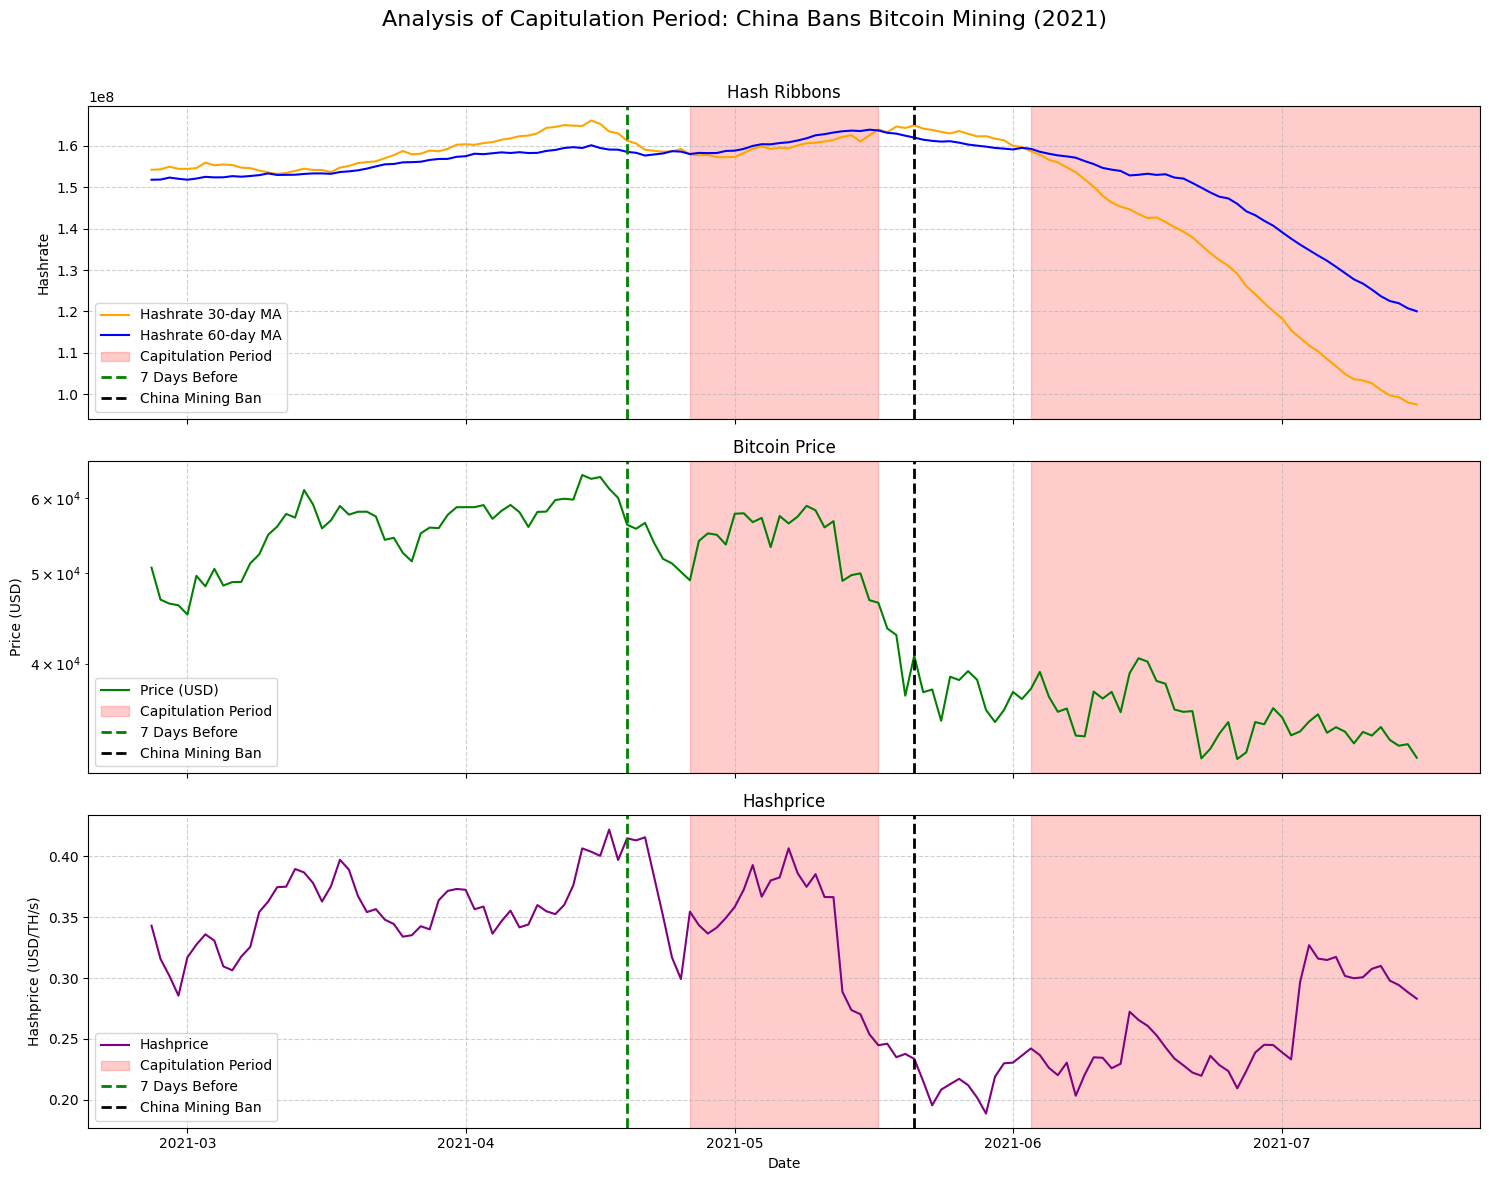

In [477]:
start_viz_str = '2021-04-26'
end_viz_str = '2021-05-17'
second_viz_str = '2021-06-03'
second_end_viz_str = '2021-08-07'

start_viz = pd.to_datetime(start_viz_str)
end_viz = pd.to_datetime(end_viz_str)

if start_viz in df.index and end_viz in df.index:
    
    sample_period = df.loc[start_viz - pd.Timedelta(days=60):end_viz + pd.Timedelta(days=60)]
    
    # Calculate 7 days before start
    seven_days_before = start_viz - pd.Timedelta(days=7)
    china_ban_date = pd.to_datetime('2021-05-21')
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
    fig.suptitle(f'Analysis of Capitulation Period: China Bans Bitcoin Mining (2021)', fontsize=16)

    # Plot hashrate and MAs
    axes[0].plot(sample_period.index, sample_period['hashrate_ma30'], label='Hashrate 30-day MA', color='orange')
    axes[0].plot(sample_period.index, sample_period['hashrate_ma60'], label='Hashrate 60-day MA', color='blue')
    axes[0].axvspan(start_viz, end_viz, color='red', alpha=0.2, label='Capitulation Period')
    axes[0].axvspan(second_viz_str, second_end_viz_str, color='red', alpha=0.2)
    axes[0].axvline(seven_days_before, color='green', linestyle='--', linewidth=2, label='7 Days Before')
    axes[0].axvline(china_ban_date, color='black', linestyle='--', linewidth=2, label='China Mining Ban')
    axes[0].set_title("Hash Ribbons")
    axes[0].set_ylabel("Hashrate")
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # Plot price
    axes[1].plot(sample_period.index, sample_period['price'], label='Price (USD)', color='green')
    axes[1].axvspan(start_viz, end_viz, color='red', alpha=0.2, label='Capitulation Period')
    axes[1].axvspan(second_viz_str, second_end_viz_str, color='red', alpha=0.2)
    axes[1].axvline(seven_days_before, color='green', linestyle='--', linewidth=2, label='7 Days Before')
    axes[1].axvline(china_ban_date, color='black', linestyle='--', linewidth=2, label='China Mining Ban')
    axes[1].set_title("Bitcoin Price")
    axes[1].set_ylabel("Price (USD)")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.6)
    axes[1].set_yscale('log')

    # Plot hashprice
    axes[2].plot(sample_period.index, sample_period['hashprice'], label='Hashprice', color='purple')
    axes[2].axvspan(start_viz, end_viz, color='red', alpha=0.2, label='Capitulation Period')
    axes[2].axvspan(second_viz_str, second_end_viz_str, color='red', alpha=0.2) 
    axes[2].axvline(seven_days_before, color='green', linestyle='--', linewidth=2, label='7 Days Before')
    axes[2].axvline(china_ban_date, color='black', linestyle='--', linewidth=2, label='China Mining Ban')    
    axes[2].set_title("Hashprice")
    axes[2].set_ylabel("Hashprice (USD/TH/s)")
    axes[2].legend()
    axes[2].grid(True, linestyle='--', alpha=0.6)

    plt.xlabel("Date")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print(f"Could not find the specified visualization period ({start_viz_str} to {end_viz_str}) in the data.")

# Model Building

In [478]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    print(f"Seed set to {seed}")

set_seed(42)

Seed set to 42


In [479]:
feature_cols = [
    # Core Hash Ribbons components
    'hashrate_ma30', 'hashrate_ma60',
    'hashrate_distance_from_ma30', 'hashrate_distance_from_ma60',
    
    # Recent changes (momentum)
    'hashrate_pct_change', 'hashprice_pct_change',
    
    # Stress indicators
    'days_below_ma60', 'consecutive_decline_days',
    
    # Volatility
    'hashrate_volatility_7d',
    
    # Lags
    'hashrate_lag1', 'hashrate_lag7'
]

X = df[feature_cols].values
y = df['target'].values

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features: {len(feature_cols)}")
print(f"Target distribution: Capitulation={y.sum()}, Recovery={len(y)-y.sum()}")

Features: 11
Target distribution: Capitulation=350.0, Recovery=1410.0


In [480]:
class CapitulationDataset(Dataset):
    def __init__(self, X, y, sequence_length=45):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.X) - self.sequence_length
    
    def __getitem__(self, idx):
        X_seq = self.X[idx:idx+self.sequence_length]
        y_label = self.y[idx+self.sequence_length]
        return torch.FloatTensor(X_seq), torch.FloatTensor([y_label])

In [481]:
sequence_length = 45
dataset = CapitulationDataset(X_scaled, y, sequence_length)

# Split
split = int(len(dataset) * 0.8)
train_indices = list(range(split))
test_indices = list(range(split, len(dataset)))


# Weighted sampler for train set (oversample minority class)
# Get labels for training set
train_labels = []
for idx in train_indices:
    _, label = dataset[idx]
    train_labels.append(label.item())

train_labels = np.array(train_labels)

# Calculate sample weights (inverse frequency)
class_counts = np.bincount(train_labels.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[train_labels.astype(int)]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Use sampler for training (this will oversample minority class)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"\nTrain: {len(train_dataset)}, Test: {len(test_dataset)}")


Train: 1372, Test: 343


In [482]:
class CapitulationGRU(nn.Module):
    def __init__(self, input_size, hidden_size=32, dropout=0.3):
        super(CapitulationGRU, self).__init__()
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_output = gru_out[:, -1, :]
        out = self.dropout(last_output)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CapitulationGRU(input_size=len(feature_cols), hidden_size=32, dropout=0.3)
model = model.to(device)

In [483]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

criterion = FocalLoss(alpha=0.8, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [484]:
num_epochs = 150
train_losses = []
val_losses = []
best_f1 = 0
patience = 30
patience_counter = 0

print("\nTraining...")
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    val_loss = 0
    val_preds = []
    val_actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            # Collect predictions for F1 calculation
            preds = (outputs.cpu().numpy() > 0.5).astype(int).flatten()
            val_preds.extend(preds)
            val_actuals.extend(y_batch.cpu().numpy().flatten().astype(int))
    
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))
    
    # Calculate F1 score
    val_f1 = f1_score(val_actuals, val_preds, zero_division=0)
    
    # Early stopping based on F1 score
    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_f1.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {val_f1:.4f}")

# Load best model
model.load_state_dict(torch.load('best_model_f1.pth'))
print(f"\n Training complete! Best F1: {best_f1:.4f}")


Training...
Epoch 10 - Train Loss: 0.0199, Val Loss: 0.0638, Val F1: 0.6535
Epoch 20 - Train Loss: 0.0126, Val Loss: 0.1175, Val F1: 0.5176
Epoch 30 - Train Loss: 0.0123, Val Loss: 0.1550, Val F1: 0.4250
Early stopping at epoch 36

 Training complete! Best F1: 0.6786


# Evaluation

In [485]:
model.eval()
probs = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs.extend(outputs.cpu().numpy().flatten())
        actuals.extend(y_batch.numpy().flatten())

probs = np.array(probs)
actuals = np.array(actuals)

precisions, recalls, thresholds = precision_recall_curve(actuals, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\nOptimal threshold for F1: {optimal_threshold:.3f}")

# Predictions with optimal threshold
predictions = (probs > optimal_threshold).astype(int)

print("\n" + "="*60)
print("FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy: {accuracy_score(actuals, predictions):.4f}")
print(f"Precision: {precision_score(actuals, predictions, zero_division=0):.4f}")
print(f"Recall: {recall_score(actuals, predictions, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(actuals, predictions, zero_division=0):.4f}")
print(f"ROC-AUC: {roc_auc_score(actuals, probs):.4f}")

print("\nClass distribution in predictions:")
print(f"Predicted Capitulation: {predictions.sum()} ({predictions.sum()/len(predictions)*100:.1f}%)")
print(f"Predicted Recovery: {len(predictions)-predictions.sum()} ({(len(predictions)-predictions.sum())/len(predictions)*100:.1f}%)")



Optimal threshold for F1: 0.487

FINAL MODEL PERFORMANCE
Accuracy: 0.8980
Precision: 0.7800
Recall: 0.6190
F1-Score: 0.6903
ROC-AUC: 0.9060

Class distribution in predictions:
Predicted Capitulation: 50 (14.6%)
Predicted Recovery: 293 (85.4%)


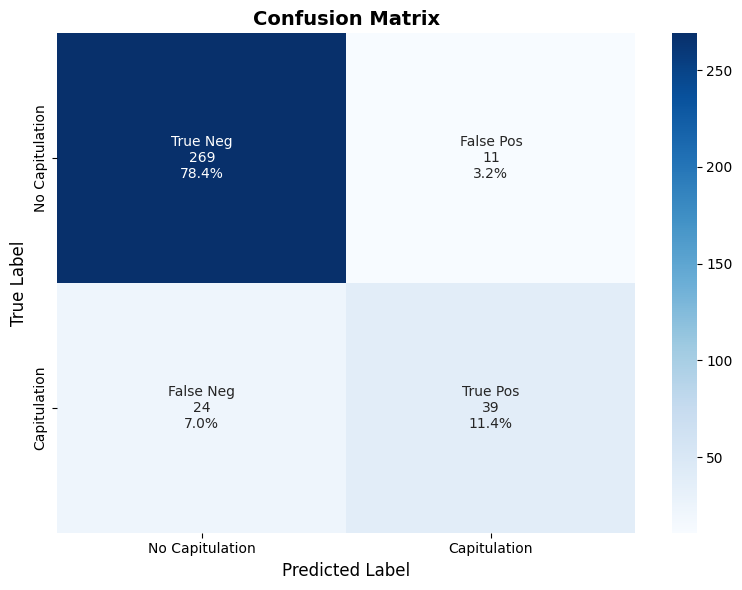

In [486]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(actuals, predictions)

# Create labels with TN, FP, FN, TP
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f'{value}' for value in cm.flatten()]
group_percentages = [f'{value:.1%}' for value in cm.flatten()/np.sum(cm)]

# Combine labels
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=True,
            xticklabels=['No Capitulation', 'Capitulation'],
            yticklabels=['No Capitulation', 'Capitulation'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [487]:
# show all successful capitulation predictions in test set
test_start_idx = split + sequence_length  # account for sequence length offset
test_dates = df.index[test_start_idx:test_start_idx + len(test_dataset)]
test_results = pd.DataFrame({
    'date': test_dates,
    'actual': actuals,
    'predicted': predictions,
    'probability': probs
})
test_results[(test_results['actual'] == 1) & (test_results['predicted'] == 1)]

,date,actual,predicted,probability
26,2025-01-24,1.0,1,0.550968
27,2025-01-25,1.0,1,0.585868
30,2025-01-28,1.0,1,0.680478
31,2025-01-29,1.0,1,0.667973
32,2025-01-30,1.0,1,0.631464
176,2025-06-23,1.0,1,0.536478
177,2025-06-24,1.0,1,0.682151
178,2025-06-25,1.0,1,0.770420
179,2025-06-26,1.0,1,0.783848
180,2025-06-27,1.0,1,0.759241
